In [1]:
import numpy as np
import os
import uuid

import joblib # for persisting models

# models
from scipy.optimize import curve_fit # multip. linear regression
from sklearn.svm import SVR # support vector forrest
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV # select hyper parameters

import pandas as pd
import time
from datetime import datetime

df = pd.read_csv('../aggregated_measurements_data.csv', index_col=0)

df_cleaned = df.dropna()
print("Dropped ", len(df) - len(df_cleaned), " rows with NaN values")
print("Remaining rows: ", len(df_cleaned))

X = df_cleaned[['distance', 'c_walls', 'w_walls', 'co2', 'humidity', 'pm25', 'pressure', 'temperature', 'snr']]
y = df_cleaned['exp_pl']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dropped  780  rows with NaN values
Remaining rows:  492451


Fitting 2 folds for each of 32 candidates, totalling 64 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
r2 training: 0.9807
r2 test: 0.9793
mse training: 10.8092
mse test: 11.5995


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

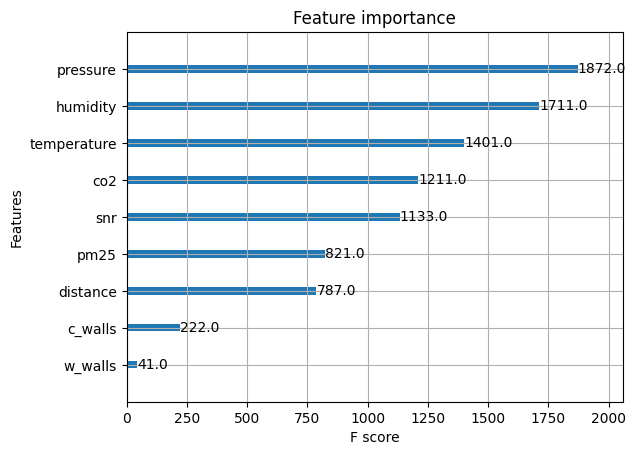

In [6]:
import xgboost as xgb

# too big for now
param_grid = {
    'n_estimators': [100, 200, 300],          # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],        # Learning rate (step size)
    'max_depth': [3, 4, 5],                   # Maximum depth of trees
    'subsample': [0.8, 0.9, 1.0],             # Fraction of samples used in training each tree
    'colsample_bytree': [0.8, 0.9, 1.0]       # Fraction of features used in training each tree
}

param_grid = {
    'n_estimators': [100, 300],          # Number of boosting rounds
    'learning_rate': [0.01, 0.2],        # Learning rate (step size)
    'max_depth': [3, 5],                 # Maximum depth of trees
    'subsample': [0.8, 1.0],             # Fraction of samples used in training each tree
    'colsample_bytree': [0.8, 1.0]       # Fraction of features used in training each tree
}

# param_grid = {
#     'n_estimators': [300],          # Number of boosting rounds
#     'learning_rate': [0.2],        # Learning rate (step size)
#     'max_depth': [5],                 # Maximum depth of trees
#     'subsample': [1.0],             # Fraction of samples used in training each tree
#     'colsample_bytree': [1.0]       # Fraction of features used in training each tree
# }

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error',
                           cv=2,  # 3-fold cross-validation
                        #    cv=3,  # 3-fold cross-validation
                           verbose=2,
                           n_jobs=-1)  # Use all available CPU cores

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

model = grid_search.best_estimator_

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"r2 training: {r2_train:.4f}")
print(f"r2 test: {r2_test:.4f}")

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"mse training: {mse_train:.4f}")
print(f"mse test: {mse_test:.4f}")

xgb.plot_importance(model)